

#                          Project : Medical Treatment

# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

You can check all details about the competition from following link :
https://www.kaggle.com/c/msk-redefining-cancer-treatment

In order to get the dataset please create a login account to Kaggle and go to this problem statement page(given above) and download 2 dataset

***training_variants.zip*** and ***training_text.zip***

## Analysis of the problem statement

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [1]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants=pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text=pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

In [4]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [6]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [7]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [8]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [9]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [11]:
data_text.shape

(3321, 2)

In [12]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [13]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confution matrix and Multi class log-loss

Ok, now we understood the problem statement. Let's work on the solution. 

We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.

In [41]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [42]:
def data_text_preprocess(total_text,ind,col):
    # Remove int values from text data as that might not be imp
    if type(total_text)is not int:
        string=""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text=re.sub('\s+',' ',str(total_text))
        # bring whole text to same lower-case scale.
        total_text=total_text.lower()
        
        
        for word in total_text.split():    
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string+=word+" "
        
        
        data_text[col][ind]=string
             
            
        

In [19]:
# Below code will take some time because its huge text (took 8 minute on my 8 GB RAM system), so run it and have a cup of coffee )

for index,row in data_text.iterrows():
    if type(row['TEXT'])is str:
        data_text_preprocess(row['TEXT'],index,'TEXT')
    

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [17]:
#merging both gene_variations and text data based on ID
result=pd.merge(data_variants,data_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


It's very important to look for missing values. Else they create problem in final analysis

In [18]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [20]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [43]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


so all missing values are gone now.

## Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [25]:
y_true=result['Class'].values
result.Gene=result.Gene.str.replace('\s+','_')
result.Variation=result.Variation.str.replace('\s+','_')


Ok, so we can now start our split process in train, test and validation data set.

In [26]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [27]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [34]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [35]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

*** Visualizing for train class distrubution***

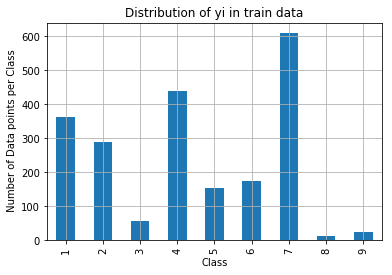

In [50]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [52]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


Let's visualize the same for test set

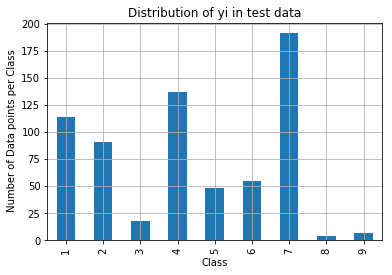

In [53]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [56]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


Let's visualize for cross validation set

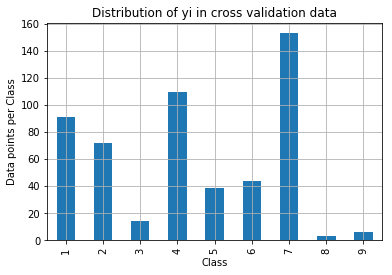

In [55]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [57]:
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this.

## Building a Random model

In [58]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [62]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y=np.zeros((cv_data_len,9))
for i in range (cv_data_len):
    random_probs=np.random.rand(1,9)
    cv_predicted_y[i]=((random_probs/sum(sum(random_probs)))[0])
print("Log loss on cross validation data using random model is",log_loss(y_cv,cv_predicted_y,eps=1e-15))

Log loss on cross validation data using random model is 2.4822505058217383


In [65]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.5405406325548228
